In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [189]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

<Figure size 1440x720 with 0 Axes>

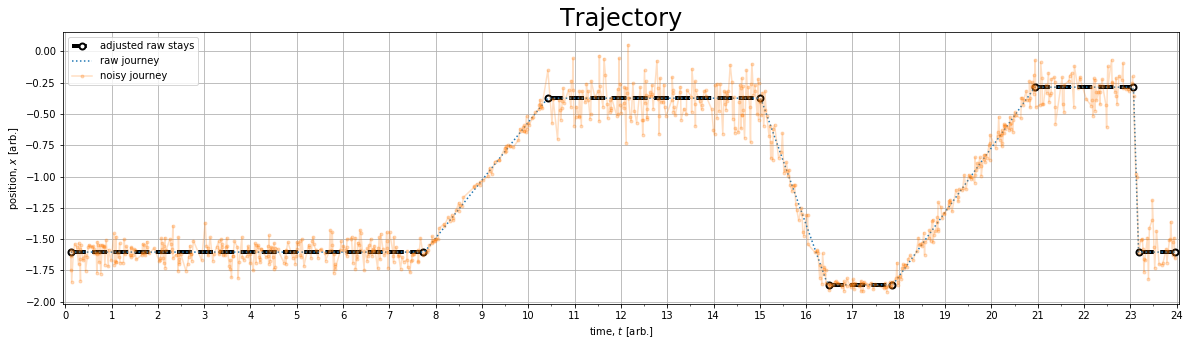

In [326]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

In [422]:
from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)
t_bounds = [10.0, 11.0, 11.5, 12.5, 13.0, 14.0]
x_locs = [0.0, 1.0, 0.0]
stays = []
for n in range(int(len(t_bounds)/2)):
    nn = 2*n
    stay = get_stay(t_bounds[nn], t_bounds[nn+1], x_locs[n])
    stays.append(stay)    

t_arr, x_arr, nx_arr, segs = get_trajectory(stays, t_total, configs)
t_segs_, x_segs_ = get_stay_segs(get_adjusted_stays(segs, t_arr))

<Figure size 1440x720 with 0 Axes>

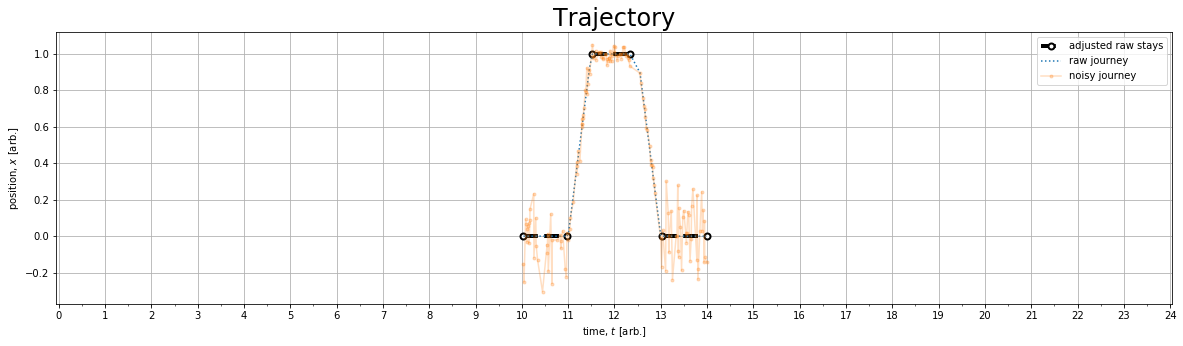

In [423]:
plt.figure(figsize=(20,10))
ax = plot_trajectory(t_arr, x_arr, nx_arr, t_segs_, x_segs_, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [327]:
time_thresh = 1/6
dist_thresh=0.25

In [328]:
clusters = list(range(time_arr.size))

In [329]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [330]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)

22

In [331]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [332]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

21

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

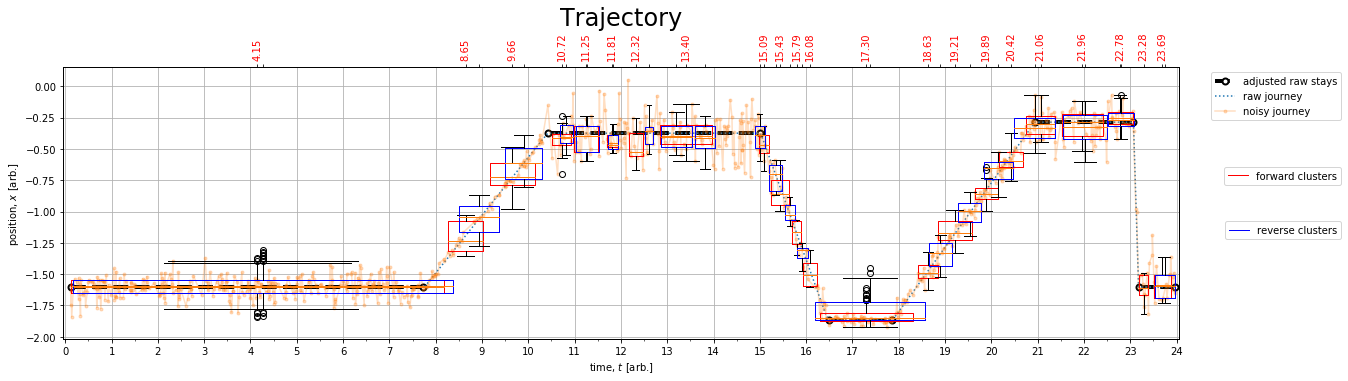

In [333]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [334]:
gaps = [time_arr[c2[0]]-time_arr[c1[-1]] for c1, c2 in zip(clusters[:-1],clusters[1:])]
for gap in gaps:
    print(gap, gap>time_thresh)

0.09111111111111114 False
0.13972222222222186 False
0.3583333333333325 True
0.055277777777778425 False
0.1899999999999995 True
0.23861111111111022 True
0.37305555555555436 True
1.0138888888888875 True
0.03638888888888836 False
0.06083333333333485 False
0.03833333333333222 False
0.06222222222222129 False
0.12388888888888872 False
0.012777777777777999 False
0.07222222222222285 False
0.021388888888889568 False
0.07083333333333641 False
0.15749999999999886 False
0.11138888888888943 False
0.131388888888889 False
0.12027777777777615 False


In [335]:
get_gap_time = lambda c1, c2: time_arr[c2[0]]-time_arr[c1[-1]]

In [336]:
#def merge_gaps(t_arr, x_arr, clusters):
new_clusters = []    
for c1, c2 in zip(clusters[:-1],clusters[1:]):

    dt = time_arr[c2[0]]-time_arr[c1[-1]]
    print(c1[0],c1[-1],c2[0],c2[-1],dt,dt>time_thresh)

0 309 311 327 0.09111111111111114 False
311 327 329 358 0.13972222222222186 False
329 358 367 379 0.3583333333333325 True
367 379 382 399 0.055277777777778425 False
382 399 406 414 0.1899999999999995 True
406 414 428 436 0.23861111111111022 True
428 436 456 488 0.37305555555555436 True
456 488 535 545 1.0138888888888875 True
535 545 547 560 0.03638888888888836 False
547 560 562 569 0.06083333333333485 False
562 569 571 578 0.03833333333333222 False
571 578 580 655 0.06222222222222129 False
580 655 657 675 0.12388888888888872 False
657 675 677 700 0.012777777777777999 False
677 700 702 721 0.07222222222222285 False
702 721 723 751 0.021388888888889568 False
723 751 753 782 0.07083333333333641 False
753 782 785 812 0.15749999999999886 False
785 812 815 832 0.11138888888888943 False
815 832 836 844 0.131388888888889 False
836 844 848 859 0.12027777777777615 False


In [337]:
n = 0
while n < len(clusters):
    c1 = clusters[n].copy()

    print(m,n,c1[0],c1[-1])
    n+=1

27 0 0 309
27 1 311 327
27 2 329 358
27 3 367 379
27 4 382 399
27 5 406 414
27 6 428 436
27 7 456 488
27 8 535 545
27 9 547 560
27 10 562 569
27 11 571 578
27 12 580 655
27 13 657 675
27 14 677 700
27 15 702 721
27 16 723 751
27 17 753 782
27 18 785 812
27 19 815 832
27 20 836 844
27 21 848 859


In [338]:
m = 0
new_clusters = []
while m < len(clusters):
    
    n = m + 1
    
    clust = clusters[m].copy()
    
    while n < len(clusters):
        c1 = clusters[m].copy()
        c2 = clusters[n].copy()
        
        gap_time = get_gap_time(clusters[m],clusters[n])
        
        print(m,n,c1[0],c1[-1],c2[0],c2[-1],clust[0],clust[-1],f"{gap_time:.3f}",int(gap_time <= time_thresh))
        
        if (gap_time <= time_thresh) & (abs(noise_arr[c1].mean()-noise_arr[c2].mean())<0.025):
            clust.extend(clusters[n])
            n+=1
        else:
            new_clusters.append(clust)
            m = n
            clust = clusters[m].copy()
            n += 1

    m += 1
new_clusters.append(clust)

0 1 0 309 311 327 0 309 0.091 1
1 2 311 327 329 358 311 327 0.140 1
2 3 329 358 367 379 329 358 0.358 0
3 4 367 379 382 399 367 379 0.055 1
3 5 367 379 406 414 367 399 0.774 0
5 6 406 414 428 436 406 414 0.239 0
6 7 428 436 456 488 428 436 0.373 0
7 8 456 488 535 545 456 488 1.014 0
8 9 535 545 547 560 535 545 0.036 1
9 10 547 560 562 569 547 560 0.061 1
10 11 562 569 571 578 562 569 0.038 1
11 12 571 578 580 655 571 578 0.062 1
12 13 580 655 657 675 580 655 0.124 1
13 14 657 675 677 700 657 675 0.013 1
14 15 677 700 702 721 677 700 0.072 1
15 16 702 721 723 751 702 721 0.021 1
16 17 723 751 753 782 723 751 0.071 1
17 18 753 782 785 812 753 782 0.157 1
17 19 753 782 815 832 753 812 1.142 0
19 20 815 832 836 844 815 832 0.131 1
20 21 836 844 848 859 836 844 0.120 1


In [339]:
new_clusters[-1][0],new_clusters[-1][-1]

(848, 859)

In [340]:
def gap_criterion(dist_thresh):

    def meth(t_arr,x_arr,c1,c2):
    
        return ((get_gap_time(c1,c2)) and \
              (abs(x_arr[c1].mean()-x_arr[c2].mean()) < dist_thresh))
    
    return meth

In [341]:
gaps = [gap_criterion(0.025)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(clusters[:-1],clusters[1:])]

In [342]:
for gap in gaps:
    print(gap)

False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False


In [347]:
def _merge_gaps(t_arr, x_arr, clusters):

    m = 0
    new_clusters = []
    while m < len(clusters):

        n = m + 1

        clust = clusters[m].copy()

        while n < len(clusters):
            c1 = clusters[m].copy()
            c2 = clusters[n].copy()

            gap_time = get_gap_time(c1,c2)

            print(m,n,c1[0],c1[-1],c2[0],c2[-1],clust[0],clust[-1],f"{gap_time:.3f}",int(gap_time <= time_thresh))

            if (gap_time <= time_thresh) & (abs(x_arr[c1].mean()-x_arr[c2].mean())<0.025):
                clust.extend(clusters[n])
                n+=1
            else:
                new_clusters.append(clust)
                m = n
                clust = clusters[m].copy()
                n += 1

        m += 1
    
    new_clusters.append(clust)        
    
    return new_clusters

In [348]:
def merge_gaps(t_arr, x_arr, clusters):
    
    new_clusters = _merge_gaps(t_arr, x_arr, clusters).copy()
    
    gaps = [gap_criterion(0.025)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]

    for gap in gaps:
        print(gap)    
    
    while any(gaps):
        
        new_clusters = merge_gaps(t_arr, x_arr, new_clusters).copy()
    
        gaps = [gap_criterion(0.025)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]
        
    return new_clusters

In [ ]:
new_clusters = merge_gaps(time_arr, noise_arr, clusters)

In [ ]:
len(new_clusters)

In [ ]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, new_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [ ]:
cbase = new_clusters[-2][0]+10

In [ ]:
clusters2 = get_clusters_rev(time_arr[cbase:], noise_arr[cbase:], dist_thresh, time_thresh)
clusters2 = [[c + cbase for c in c_inner] for c_inner in clusters2]

In [ ]:
clusters2

In [ ]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, new_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters2)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='green'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [350]:
configs['count_thresh'] = 10

In [351]:
def extend_cluster(t_arr, x_arr, cluster, configs, verbose=False):
    
    results = extend_edge(t_arr, x_arr, cluster[-1], cluster[0], [x_arr[cluster].mean()], configs, verbose)

    cluster += results[1]

    results = extend_edge(t_arr, x_arr, cluster[0], cluster[-1], [x_arr[cluster].mean()], configs, verbose)

    cluster = results[1] + cluster

    return cluster

In [352]:
def intersecting_bounds(a1,a2,b1,b2):
    
    return (((a1 >= b1) & (a1 <= b2)) | 
            ((a2 >= b1) & (a2 <= b2)) | 
            ((b1 >= a1) & (b1 <= a2)) | 
            ((b2 >= a1) & (b2 <= a2)))    

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])

In [396]:
def extend_clusters(t_arr, x_arr, clusters, configs, verbose=False):
    
    from stay_classification.box_classifier.box_method import extend_edge

    new_clusters = [extend_cluster(t_arr, x_arr, clusters[0].copy(), configs, verbose)]
    
    for clust in clusters[1:]:
        
        c = extend_cluster(t_arr, x_arr, clust.copy(), configs, verbose)
        
        # check the IQR is within the allowed threshold
        dist_criterion = False
        if get_iqr(x_arr[c])<2*dist_thresh:
            dist_criterion = True
            
        c_last = new_clusters[-1]            
        
        # Check if new cluster overlaps with the previous one
        embed_criterion = False
        if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)        
        
        print(f"[{ clust[0]:4d},{ clust[-1]:4d}]," + "\t"\
              f"{t_arr[clust[0]]:6.3f}...{t_arr[clust[-1]]:6.3f}" + "\t"\
              f"{x_arr[clust].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[clust]):6.3f}," + "\t\t\t"\
              f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
              f"{t_arr[c[0]]:6.3f}...{t_arr[c[-1]]:6.3f}" + "\t"\
              f"{x_arr[c].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[c]):6.3f},", \
              dist_criterion, embed_criterion)
        
        
        # check the IQR is within the allowed threshold
        dist_criterion0 = False
        if get_iqr(x_arr[clust])<2*dist_thresh:
            dist_criterion0 = True
                    
        # Check if new cluster overlaps with the previous one
        embed_criterion0 = False
        if len(new_clusters)>0:
            embed_criterion0 = inter_bounds(clust,c_last) 
            
        if dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        elif dist_criterion0 & (not embed_criterion0) & (get_iqr(x_arr[clust]) < get_iqr(x_arr[c])):
            new_clusters.append(clust)
        '''if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)
            print(f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
                  f"[{c_last[0]:4d},{c_last[-1]:4d}]")

        # ... if there is an overlap, get the one with the smaller IQR
        # ... 1. remove last, append new if dist_crit == True
        if dist_criterion & embed_criterion:
            if get_iqr(noise_arr[c])<get_iqr(noise_arr[c_last]):
                new_clusters[-1] = c       
            else:
                pass
        # ... if no overlap and dist_crit == True, append
        elif dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        else:
            pass'''
    
    return new_clusters

In [397]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)

In [398]:
ext_clusters = extend_clusters(time_arr, noise_arr, clusters, configs)

[ 311, 327],	 8.269... 9.022	-1.203,	 0.238,			[ 310, 570],	 8.179...15.911	-0.582,	 0.357, True True
[ 329, 358],	 9.162...10.153	-0.711,	 0.182,			[ 328, 570],	 9.127...15.911	-0.522,	 0.303, True True
[ 367, 379],	10.511...10.930	-0.431,	 0.084,			[ 366, 567],	10.422...15.796	-0.507,	 0.291, True False
[ 382, 399],	10.985...11.514	-0.418,	 0.205,			[ 381, 567],	10.961...15.796	-0.507,	 0.291, True True
[ 406, 414],	11.704...11.926	-0.437,	 0.094,			[ 405, 567],	11.664...15.796	-0.507,	 0.291, True True
[ 428, 436],	12.164...12.469	-0.473,	 0.181,			[ 427, 567],	12.158...15.796	-0.507,	 0.291, True True
[ 456, 488],	12.842...13.958	-0.382,	 0.154,			[ 455, 567],	12.825...15.796	-0.507,	 0.291, True True
[ 535, 545],	14.972...15.199	-0.468,	 0.145,			[ 534, 576],	14.971...16.194	-0.538,	 0.313, True True
[ 547, 560],	15.235...15.632	-0.833,	 0.203,			[ 546, 584],	15.217...16.380	-1.110,	 0.614, False True
[ 562, 569],	15.693...15.890	-1.177,	 0.184,			[ 561, 701],	15.653...19.641	-1.5

In [399]:
len(ext_clusters)

8

In [400]:
c = ext_clusters[0]
print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")
for n, c in enumerate(ext_clusters[1:]):
    
    print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")

[   0, 331] = -1.573,  0.110,
[ 366, 567] = -0.507,  0.291,
[ 571, 578] = -1.484,  0.179,
[ 580, 655] = -1.826,  0.064,
[ 657, 675] = -1.470,  0.106,
[ 677, 700] = -1.149,  0.155,
[ 701, 843] = -0.564,  0.472,
[ 847, 863] = -1.294,  0.464,


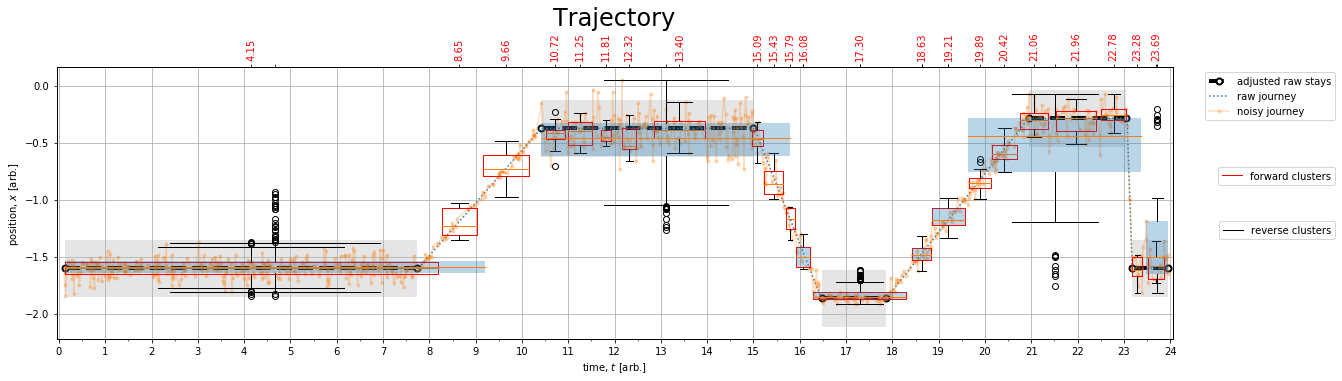

In [410]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, ext_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, patch_artist=True, boxprops=dict(color='cyan',alpha=0.3, linewidth=0 ), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

### Refinement with `box_method`

In [47]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box,get_directional_indices

In [48]:
from collections import Counter

In [49]:
def sample_times(indices,frac=0.8):
    return np.sort(np.random.choice(np.array(indices),int(frac*len(indices)), replace=False)).tolist()
    

In [50]:
configs['slope_time_thresh'] = 0.05
configs['slope_thresh'] = abs(dist_thresh/time_thresh)
configs['count_thresh'] = 10
configs['dist_thresh'] = 0.125

start_ind, last_ind = clusters[0][0], clusters[0][-1]

init_pairs = []
final_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    indices = sample_times(range(len(time_arr)),0.99)
    
    start_ind, last_ind, mean, keep = box_classifier_core(time_arr[indices], noise_arr[indices], start_ind, last_ind, timepoint, init_pairs, configs, False)

    if keep:
        final_pairs.append((start_ind, last_ind))
    else:
        continue
    init_pairs.append([cluster[0], cluster[-1]])
    
final_pairs = list(set(final_pairs))
final_pairs

[(218, 687),
 (217, 688),
 (102, 167),
 (117, 181),
 (177, 224),
 (218, 688),
 (219, 689),
 (656, 853),
 (1, 157),
 (1, 158),
 (570, 786)]

In [51]:
mid_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    # Get a box for a given timepoint
    mean, start_ind, last_ind = make_box(time_arr, noise_arr, timepoint, configs, False)
            
    mid_pairs.append([start_ind, last_ind,])

mid_pairs

[[1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [94, 182],
 [109, 192],
 [170, 236],
 [212, 706],
 [212, 706],
 [212, 706],
 [212, 711],
 [569, 805],
 [654, 863]]

`for m in range(len(final_pairs)):
    for n in range(m,len(final_pairs)):
        s1 = set(list(range(final_pairs[m][0],final_pairs[m][1]+1)))
        s2 = set(list(range(final_pairs[n][0],final_pairs[n][1]+1)))
        print(s1.isdisjoint(s2))`

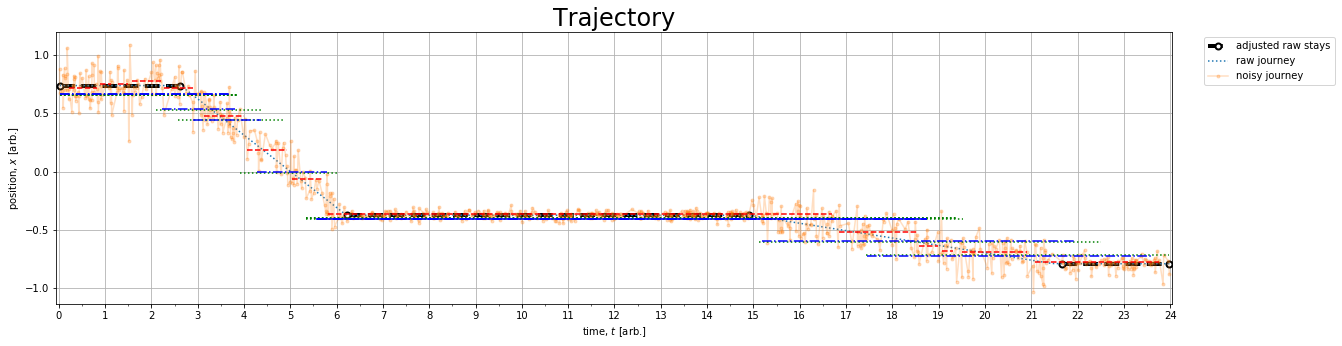

In [52]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])+.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')

for pair in mid_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:')
    
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])-.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [53]:
pairs_dur = {}
for p in final_pairs:
    dt = time_arr[p[-1]]-time_arr[p[0]]
    
    pairs_dur[tuple(p)] = dt

In [54]:
pairs_dur = {k: v for k, v in sorted(pairs_dur.items(), key=lambda item: item[1], reverse=True)}

In [55]:
pairs_dur

{(217, 688): 13.195833333333335,
 (218, 688): 13.172777777777778,
 (218, 687): 13.16472222222222,
 (219, 689): 13.130555555555555,
 (570, 786): 6.786111111111113,
 (656, 853): 6.184166666666666,
 (1, 158): 3.6602777777777775,
 (1, 157): 3.658888888888889,
 (102, 167): 1.5597222222222222,
 (177, 224): 1.4944444444444445,
 (117, 181): 1.481666666666667}

### Shifting boxes

In [56]:
from synthetic_data.trajectory import get_stay_indices

true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [57]:
final_pairs = sorted(final_pairs, key = lambda x: x[0])

In [58]:
def get_box_indices(arr, lower, upper):
    return np.where(((arr > lower) & (arr < upper)))

In [64]:
def shift_box(t_arr, x_arr, dist_thresh=None):

    def meth(pair, shift):
        
        x_arr_ = noise_arr[pair[0]:pair[1]+1]
        t_arr_ = time_arr[pair[0]:pair[1]+1]

        mean_ = x_arr_.mean()

        t0,t1 = t_arr_[0],t_arr_[-1]    

        shift = (t1-t0)/8
        mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
        mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

        x_arr_n = x_arr_[mask_n]
        t_arr_n = t_arr_[mask_n]
        x_arr_p = x_arr_[mask_p]  
        t_arr_p = t_arr_[mask_p]        

        mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
        mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)       
        
        #return abs(x_arr_[mean_mask_n].mean()-mean_), abs(x_arr_[mean_mask_p].mean()-mean_)
        return (abs(x_arr_n[mean_mask_n].mean()-mean_) < 0.025) & (abs(x_arr_p[mean_mask_p].mean()-mean_) < 0.025)
    
    
    return meth

In [65]:
len(final_pairs)

11

In [66]:
last_pairs = []
n=0
for pair in final_pairs:
    cond = shift_box(time_arr, noise_arr, dist_thresh)(pair, time_thresh/2)
    if cond: last_pairs.append(pair)
    print(n,pair, cond)
    n+=1

0 (1, 157) False
1 (1, 158) False
2 (102, 167) True
3 (117, 181) True
4 (177, 224) True
5 (217, 688) True
6 (218, 687) True
7 (218, 688) True
8 (219, 689) True
9 (570, 786) True
10 (656, 853) True


0.7095720555240634 0.6743629215779573 0.676439600659611


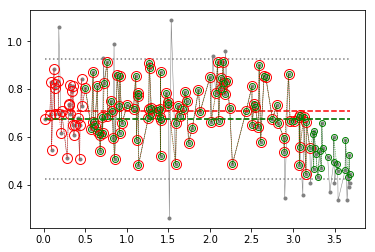

In [67]:
pair = final_pairs[1]

shift = time_thresh/2

x_arr_ = noise_arr[pair[0]:pair[1]+1]
t_arr_ = time_arr[pair[0]:pair[1]+1]

mean_ = x_arr_.mean()

t0,t1 = t_arr_[0],t_arr_[-1]    

shift = (t1-t0)/8
mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

x_arr_n = x_arr_[mask_n]
t_arr_n = t_arr_[mask_n]
x_arr_p = x_arr_[mask_p]  
t_arr_p = t_arr_[mask_p]        

mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)   

plt.plot(t_arr_, x_arr_, '.-', color='gray', lw=0.5)

plt.plot([t_arr_[0],t_arr_[-1]],[mean_,mean_], "--", color='gray', markersize=1)
plt.plot([t_arr_[0],t_arr_[-1]],[mean_+dist_thresh,mean_+dist_thresh], ":", color='gray')
plt.plot([t_arr_[0],t_arr_[-1]],[mean_-dist_thresh,mean_-dist_thresh], ":", color='gray')

#plt.plot(t_arr_n, x_arr_n, 'ro', markerfacecolor="None")
plt.plot(t_arr_n[mean_mask_n], x_arr_n[mean_mask_n], 'ro:', lw=0.7, markerfacecolor="None", markersize=10)
mean_n = x_arr_n[mean_mask_n].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_n,mean_n], "--", color='r', markersize=1)


plt.plot(t_arr_p[mean_mask_p], x_arr_p[mean_mask_p], 'go:', lw=0.7, markerfacecolor="None", markersize=6)
mean_p = x_arr_p[mean_mask_p].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_p,mean_p], "--", color='g', markersize=1)
#print(abs(mean_p-mean_)<0.01,abs(mean_n-mean_)<0.01)
print(mean_n,mean_,mean_p)

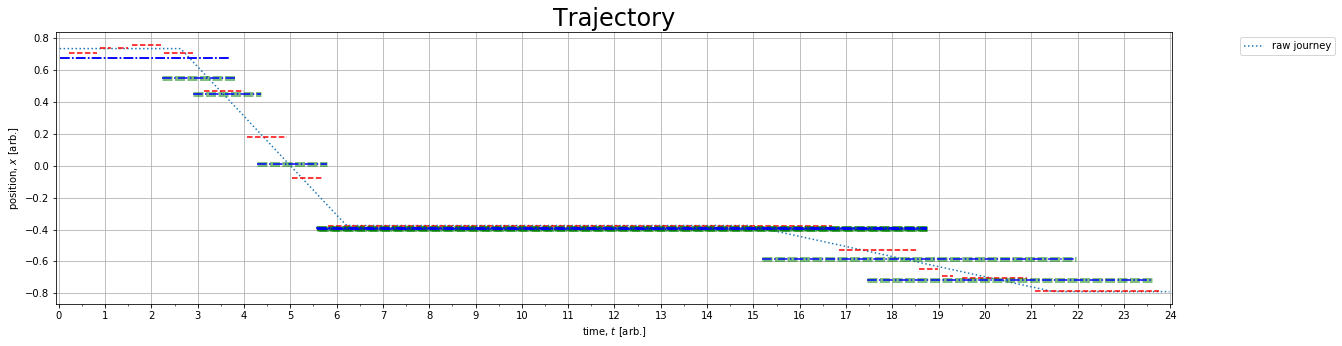

In [68]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#'''
for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')#'''

for pair in last_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:', lw=5, dashes=[2,0.5], alpha=0.5)
    
#'''
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')#'''
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [1]:
1

1

In [81]:
intersecting_bounds(1,4,2,3), \
intersecting_bounds(2,3,1,4), \
intersecting_bounds(1,3,2,4), \
intersecting_bounds(2,4,1,3), \
intersecting_bounds(1,2,3,4), \
intersecting_bounds(3,4,1,2)


(True, True, True, True, False, False)

In [82]:
new_last_pairs = []

for m in range(len(last_pairs)):

    n = m+1
    while keep_going
        #for n in range(m+1,len(last_pairs)):
        
        print(last_pairs[m], last_pairs[n])
        
        if inter_bounds(last_pairs[m], last_pairs[n]):
            
            l1 = list(range(last_pairs[m][0],last_pairs[m][1]+1))
            l2 = list(range(last_pairs[n][0],last_pairs[n][1]+1))

            len1 = len(l1)
            len2 = len(l2)        

            s1 = set(l1)
            s2 = set(l2)

            ilen1 = len(list(s1.intersection(s2)))
            ilen2 = len(list(s2.intersection(s1)))

            print(last_pairs[m], len1, last_pairs[n], len2,ilen1,ilen2)
            
            if ilen1/len1 > 0.8:
                new_last_pairs.append(last_pairs[m])
        else:
            new_last_pairs.append(last_pairs[m])
        
        n += 1
                            

SyntaxError: invalid syntax (<ipython-input-82-e2bb16c5f24a>, line 6)

In [83]:
new_last_pairs

NameError: name 'new_last_pairs' is not defined